In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def load_csv(path):
  return pd.read_csv(path, dtype={'ロケーションID': 'string'})

In [2]:
# 元データの読み込み
all_data_path = 'all.csv'
df = load_csv(all_data_path)

In [3]:
# column要素を変換
columns_name = df.columns.values.tolist()
change_name = ['category', 'sex', 'area', 'place', 'age', 'traffic', 'man', 'woman',
               '0', '10', '20', '30', '40', '50', '60', 'time', 'month', 'day',
               'roi', 'cost']

for index, name in enumerate(columns_name):
  df.rename(columns={name: change_name[index]}, inplace=True)

df.head()

,category,sex,area,place,age,traffic,man,woman,0,10,20,30,40,50,60,time,month,day,roi,cost
0,化粧品(0),男(0),栄,3,10,900,620,280,20,120,150,140,160,150,160,7,4,平日(0),103.62,80
1,化粧品(0),女(1),仙台駅前,14,60,1180,770,410,20,150,200,190,210,200,210,8,4,平日(0),101.53,100
2,化粧品(0),どちらも(3),仙台駅前,15,10,1200,980,220,20,160,200,190,220,200,210,9,4,平日(0),126.29,90
3,化粧品(0),女(1),梅田,26,20,940,810,130,20,120,160,150,170,160,160,10,4,平日(0),80.60,120
4,化粧品(0),女(1),梅田,23,10,560,480,80,10,70,100,90,100,100,90,11,4,平日(0),67.21,70


In [4]:
# # 値の変換
# def replace_values(df, column_name):
#     unique_values = dict.fromkeys(df[column_name].values.tolist())
#     for index, name in enumerate(unique_values):
#         df[column_name] = df[column_name].replace(name, index)

# columns_to_replace = ['category', 'sex', 'day']
# for column in columns_to_replace:
#     replace_values(df, column)

# df.head(10)

In [5]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best params: {'depth': 6, 'iterations': 800, 'learning_rate': 0.01}
MSE: 19.188310456216595
MAE: 3.37005409538549


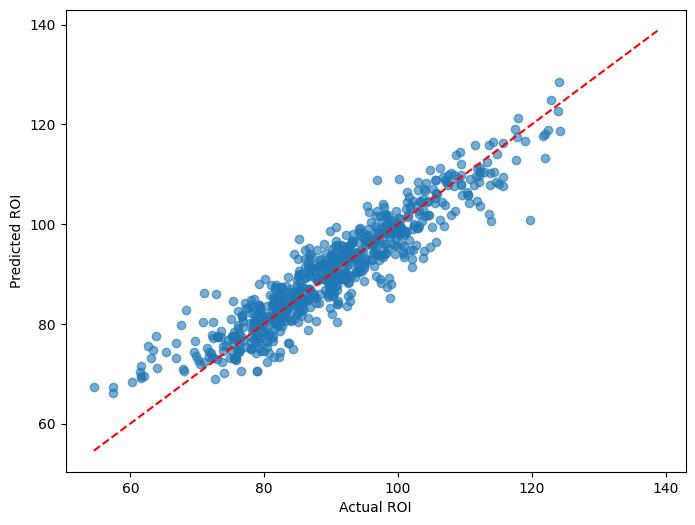

In [6]:
# モデルの作成およびグリッドサーチによる適切なパラメータの探索
X = df[['category', 'sex', 'place', 'age', 'time', 'month', 'day', 'cost']]
y = df['roi']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cat_features = ['category', 'sex', 'place', 'time', 'month','day']

base_model = CatBoostRegressor(random_seed=42, verbose=False)

param_grid = {
    # 'depth': [6, 8, 10],
    # 'learning_rate': [0.01, 0.05, 0.1],
    # 'iterations': [200, 500, 800],
    'depth': [6],
    'learning_rate': [0.01],
    'iterations': [800],
}

grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
)
grid.fit(X_train, y_train, cat_features=cat_features)

best_model = grid.best_estimator_
print("Best params:", grid.best_params_)
best_model.save_model('best_model.cbm')

y_pred = best_model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual ROI')
plt.ylabel('Predicted ROI')
plt.show()

In [7]:
# X = df[['category', 'sex', 'age', 'cost', 'place', 'month']]
# y = df['roi']

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# cat_features = ['category', 'sex', 'place', 'month']

# base_model_2 = CatBoostRegressor(random_seed=42, verbose=False)

# param_grid = {
#     # 'depth': [6, 8, 10],
#     # 'learning_rate': [0.01, 0.05, 0.1],
#     # 'iterations': [200, 500, 800],
#     'depth': [6],
#     'learning_rate': [0.01],
#     'iterations': [800],
# }

# grid = GridSearchCV(
#     estimator=base_model_2,
#     param_grid=param_grid,
#     cv=3,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,
#     verbose=1,
# )
# grid.fit(X_train, y_train, cat_features=cat_features)

# best_model_2 = grid.best_estimator_
# print("Best params:", grid.best_params_)
# best_model_2.save_model('best_model_place_and_month.cbm')

# y_pred = best_model_2.predict(X_test)
# print("MSE:", mean_squared_error(y_test, y_pred))
# print("MAE:", mean_absolute_error(y_test, y_pred))

# plt.figure(figsize=(8, 6))
# plt.scatter(y_test, y_pred, alpha=0.6)
# plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
# plt.xlabel('Actual ROI')
# plt.ylabel('Predicted ROI')
# plt.title('Actual vs Predicted (CatBoost)')
# plt.show()

In [8]:

# # 3) ユーザーが設定する具体的な入力値
# category_input = '化粧品(0)'   # 宣伝する商品カテゴリ
# sex_input      = '男(0)'      # 対象性別
# age_input      = 30           # 対象年齢
# cost_input     = 80           # 投資額(万円)

# # 2) モデルのロード
# best_model_1 = CatBoostRegressor()
# best_model_1.load_model('best_model_1.cbm')

# best_model_2 = CatBoostRegressor()
# best_model_2.load_model('best_model_2.cbm')

# # ===== 1) 「ロケーションのみ」での上位／下位5 =====
# places = df['place'].unique()
# df_place = pd.DataFrame({
#     'category': [category_input] * len(places),
#     'sex':      [sex_input]      * len(places),
#     'age':      [age_input]      * len(places),
#     'cost':     [cost_input]     * len(places),
#     'place':    places
# })
# df_place['predicted_roi'] = best_model_1.predict(
#     df_place[['category','sex','age','cost','place']]
# )
# top5_place    = df_place.nlargest(5, 'predicted_roi')
# bottom5_place = df_place.nsmallest(5, 'predicted_roi')

# print("=== 指定入力に対する上位5ロケーション ===")
# display(top5_place)
# print("\n=== 指定入力に対する下位5ロケーション ===")
# display(bottom5_place)


# # ===== 2) 「月のみ」での上位／下位5 （ロケーション固定の場合） =====
# # 例として最初のロケーションを固定
# place_input = places[0]
# months = df['month'].unique()
# df_month = pd.DataFrame({
#     'category': [category_input] * len(months),
#     'sex':      [sex_input]      * len(months),
#     'age':      [age_input]      * len(months),
#     'cost':     [cost_input]     * len(months),
#     'place':    [place_input]    * len(months),
#     'month':    months
# })
# df_month['predicted_roi'] = best_model_2.predict(
#     df_month[['category','sex','age','cost','place','month']]
# )
# top5_month    = df_month.nlargest(5, 'predicted_roi')
# bottom5_month = df_month.nsmallest(5, 'predicted_roi')

# print("\n=== 指定入力（ロケーション固定）に対する月別 ROI 上位5 ===")
# display(top5_month)
# print("\n=== 指定入力（ロケーション固定）に対する月別 ROI 下位5 ===")
# display(bottom5_month)


# # ===== 3) 「月＋ロケーション全組み合わせ」での上位／下位5 =====
# months = df['month'].unique()
# places = df['place'].unique()
# comb   = list(itertools.product(months, places))
# df_mpl = pd.DataFrame(comb, columns=['month','place'])
# df_mpl['category'] = category_input
# df_mpl['sex']      = sex_input
# df_mpl['age']      = age_input
# df_mpl['cost']     = cost_input

# df_mpl['predicted_roi'] = best_model_2.predict(
#     df_mpl[['category','sex','age','cost','place','month']]
# )
# top5_mpl    = df_mpl.nlargest(5, 'predicted_roi')
# bottom5_mpl = df_mpl.nsmallest(5, 'predicted_roi')

# print("\n=== 指定入力に対する月＋ロケーション別 ROI 上位5 ===")
# display(top5_mpl)
# print("\n=== 指定入力に対する月＋ロケーション別 ROI 下位5 ===")
# display(bottom5_mpl)